# Day1 signal

The starting point for the post result project

**Index**
- Packages
- Data acquisition
- Utility functions
    - General helper
    - Signal functions
    - Performance utility functions
- Average return trajectory for short
- Account curve for long
    - Variations including time periods, entry point, question around earning, stop loss, moving average, high, size, country, sector, PE, market correlation
    - Possible combinations of signal building blocks
    - US vs Europe
- Average return trajectory for short
- Account curve for short
    - Same logic
- Build a portfolio


## 1 - Packages import

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
from scipy import stats
from textwrap import wrap
import seaborn as sns
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score


%matplotlib inline

## 2 - Data acquisition

Store the data in excel and extract them from following functions
- Fundamental data including revision, market cap, volume, PE, sector
- Absolute price, relative price, absolute return, relative return

In [2]:
#initial cleaning function
def clean_sheet(dataframe):
    adj=dataframe.dropna(axis=1,how='all')
    adj=dataframe.set_index(adj.columns[0]) #use stock tickers as the index
    return adj

In [3]:
#pull the data from excel, form a dictionary of tab names and dataframes
tabs_to_grab=['Quarter','Date','Revision','Market cap','Volume','PE','PE premium','Property']

# Europe
data_dict_Europe={}

for s in tabs_to_grab:
    df=clean_sheet(pd.read_excel(r'C:\Users\Eric.Li\Documents\Post result data\Europe reference.xlsx',sheet_name=s))
    data_dict_Europe[s]=df
    
# select the right universe for Europe
universe_evaluate_Europe=(data_dict_Europe["Market cap"]>500)&(data_dict_Europe["Volume"]>3)
data_dict_Europe["Revision"]=data_dict_Europe["Revision"][universe_evaluate_Europe]
#data_dict_Europe["Date"]=data_dict_Europe["Date"][universe_evaluate_Europe]
data_dict_Europe["Market cap"]=data_dict_Europe["Market cap"][data_dict_Europe["Market cap"]>500]

In [4]:
#pull the data from excel, form a dictionary of tab names and dataframes
tabs_US=['Quarter','Date','Revision','Market cap','Volume','PE','PE premium','Property']

# Europe
data_dict_US={}

for s in tabs_US:
    df=clean_sheet(pd.read_excel(r'C:\Users\Eric.Li\Documents\Post result data\US reference.xlsx',sheet_name=s))
    data_dict_US[s]=df
    
# select the right universe for Europe
universe_evaluate_US=(data_dict_US["Market cap"]>500)&(data_dict_US["Volume"]>3)
data_dict_US["Revision"]=data_dict_US["Revision"][universe_evaluate_US]
#data_dict_Europe["Date"]=data_dict_Europe["Date"][universe_evaluate_Europe]
data_dict_US["Market cap"]=data_dict_US["Market cap"][data_dict_US["Market cap"]>500]

In [5]:
tabs_global=['Quarter','Date','Revision','Market cap','Volume','PE','PE premium','Property']

# Global
data_dict_global={}

for s in tabs_global:
    df=data_dict_Europe[s].append(data_dict_US[s])
    data_dict_global[s]=df

In [6]:
tabs_Asia=['Quarter','Date','Revision','Market cap','Volume','PE','PE premium','Property','Mapping']

# Asia
data_dict_Asia={}

for s in tabs_Asia:
    df=clean_sheet(pd.read_excel(r'C:\Users\Eric.Li\Documents\Post result data\Asia reference.xlsx',sheet_name=s))
    country=df.apply(lambda x:x.name[-2:] if type(x.name)==str else 0,axis=1)
    data_dict_Asia[s]=df

# select the right universe for Asia
universe_evaluate_Asia=(data_dict_Asia["Market cap"]>500)&(data_dict_Asia["Volume"]>3)
data_dict_Asia["Revision"]=data_dict_Asia["Revision"][universe_evaluate_Asia]
data_dict_Asia["Market cap"]=data_dict_Asia["Market cap"][data_dict_Asia["Market cap"]>500]

In [7]:
# get the price dataframe for certain years; form the price and return datetime from the data from all the years 
def price_from_excel(path, start_year,end_year):
    
    year_range=range(start_year,end_year+1)

    price_list=[]

    for year in year_range:
        price_year=clean_sheet(pd.read_excel(path,sheet_name=str(year))).dropna(how='all',axis=0)
        price_list.append(price_year)

    price=pd.concat(price_list,axis=1).dropna(axis=1,how='all').dropna(axis=0,how='all')

    # transform the datetime to the common timestamp format
    price_column=[i.strftime("%d/%b/%Y") for i in price.columns.tolist() if type(i)!=str]
    price.columns=price_column
    
    return price

In [8]:
# get price_df
price_Europe=price_from_excel(r'C:\Users\Eric.Li\Documents\Post result data\Europe price reference.xlsx',2017,2018)
price_US=price_from_excel(r'C:\Users\Eric.Li\Documents\Post result data\US price reference.xlsx',2017,2018)


In [9]:
price_Asia=price_from_excel(r'C:\Users\Eric.Li\Documents\Post result data\Asia price reference.xlsx',2017,2018)

In [10]:
def get_return(price_df,benchmark,sector_df):
    rel_price=price_df/price_df.loc[benchmark]
    rel_price=rel_price.dropna(how='all',axis=0)
    abs_return=price_df.diff(1,axis=1)/price_df.shift(1,axis=1)
    abs_return=abs_return.dropna(how='all',axis=0)
    rel_return=abs_return - abs_return.loc[benchmark]
    rel_return=rel_return.dropna(how='all',axis=0)
    #rel_return_sector=abs_return.dropna(axis=0,how='all').apply(lambda x: x-abs_return.loc[sector_df.loc[x.name].Index] if x.name[-2:]!='CN' and x.name[-3:-2]==' ' and not pd.isnull(sector_df.loc[x.name].Index) else x,axis=1)
    #abs_open_ret=open_price/price_df.shift(1,axis=1)-1
    #rel_open_ret=abs_open_ret-abs_open_ret.loc[benchmark]
    return rel_price,abs_return,rel_return

In [11]:
def get_return_Asia(price_df,mapping_df):
    abs_return=price_df.diff(1,axis=1)/price_df.shift(1,axis=1)
    abs_return=abs_return.dropna(how='all',axis=0)
    stock_return=abs_return.copy()
    stock_return["country"]=stock_return.apply(lambda x:x.name[-2:],axis=1)
    stock_return=stock_return[(stock_return["country"]!='ex')&(stock_return["country"]!='IN')]
    stock_return["Index"]=stock_return["country"].apply(lambda x: mapping_df.loc[x].iloc[0]).values
    benchmark_return=stock_return.apply(lambda x:abs_return.loc[x.Index],axis=1)
    rel_return=stock_return.iloc[:,:-2] - benchmark_return
    rel_return=rel_return.dropna(how='all',axis=0)
    return abs_return,rel_return,benchmark_return

In [12]:
# get return dfs
rel_price_Europe,abs_return_Europe,rel_return_Europe=get_return(price_Europe,'SX5E Index',data_dict_Europe["Property"])
rel_price_US,abs_return_US,rel_return_US=get_return(price_US,'SPX Index',data_dict_US["Property"])

In [13]:
# get return dfs
abs_return_Asia,rel_return_Asia,benchmark_return_Asia=get_return_Asia(price_Asia,data_dict_Asia["Mapping"])

## 3 - Utility functions

Collect all the utility functions in one place

### 3.1 General helper functions
- Calculation incl. nmove, vol, sector, market cap, EAR
- AUTOR, MA

In [14]:
# utility function to obtain announcement return (as a multiplier of vol) as a result of day 0 and return dataframe
def EAR_calc(ticker,date,return_df,EAR_period,vol_lookback):
    if type(date)==pd._libs.tslib.NaTType:
        return None
    elif type(date)==pd._libs.tslib.Timestamp:
        date=date.strftime("%d/%b/%Y")
    elif type(date)==str:
        date=date
    return_series=return_df.loc[ticker].dropna()
    date_series=return_series.index.tolist()
    if date in date_series:
        day0=date_series.index(date)
        post_series=return_series.iloc[day0:]
        pre_series=return_series.iloc[:day0]
        vol= return_series.iloc[day0-min(len(pre_series),vol_lookback+1):day0].std()
        ret=(return_series.iloc[day0:day0+EAR_period]+1).prod()-1
        nmove=ret/vol
        return nmove
    else:
        return None

In [15]:
# obtain the announcement return dataframe from price return and date dataframe
def EAR_df(date_df,return_df,EAR_period,vol_lookback):
    EAR_list=[]
    for ticker, date_row in date_df.iterrows():
        if type(ticker)==str: #deal with None
            ret_series=date_row.apply(lambda x: EAR_calc(ticker,x,return_df,EAR_period,vol_lookback))
            EAR_list.append(ret_series)
        else:
            pass
    EAR_df=pd.concat(EAR_list,axis=1).T
    return EAR_df

In [16]:
## function to grab volume
def get_volume(ticker,date,volume_df,date_df):
    date_series=date_df.loc[ticker]
    volume_series=volume_df.loc[ticker]
    if type(date)==pd._libs.tslib.Timestamp:
        timestamp=date
    elif type(date)==str:
        timestamp=pd.Timestamp(datetime.strptime(date,"%d/%b/%Y").year,
                               datetime.strptime(date,"%d/%b/%Y").month,
                               datetime.strptime(date,"%d/%b/%Y").day)
    else:
        return None
    try:
        location=date_series.tolist().index(timestamp)
        volume=volume_series.iloc[location]
        return volume
    except ValueError:
        return None

In [17]:
# utility function to obtain the gap
def gap_calc(ticker,date,open_ret,return_df,vol_lookback):
    if type(date)==pd._libs.tslib.NaTType:
        return None
    elif type(date)==pd._libs.tslib.Timestamp:
        date=date.strftime("%d/%b/%Y")
    elif type(date)==str:
        date=date
    open_ret_series=open_ret.loc[ticker].dropna()
    return_series=return_df.loc[ticker].dropna()
    date_series=open_ret_series.index.tolist()
    if date in date_series:
        day0=date_series.index(date)
        pre_series=return_series.iloc[:day0]
        vol= return_series.iloc[day0-min(len(pre_series),vol_lookback+1):day0].std()
        ret=open_ret_series.iloc[day0]
        nmove=ret/vol     
        return nmove
    else:
        return None

In [18]:
# obtain the announcement return dataframe from price return and date dataframe
def gap_df(date_df,open_ret,return_df,vol_lookback):
    gap_list=[]
    for ticker, date_row in date_df.iterrows():
        if type(ticker)==str: #deal with None
            gap_series=date_row.apply(lambda x: gap_calc(ticker,x,open_ret,return_df,vol_lookback))
            gap_list.append(gap_series)
        else:
            pass
    gap_df=pd.concat(gap_list,axis=1).T
    return gap_df

In [19]:
## function to grab market cap
def get_market_cap(ticker,date,market_cap_df,date_df):
    date_series=date_df.loc[ticker]
    size_series=market_cap_df.loc[ticker]
    if type(date)==pd._libs.tslib.Timestamp:
        timestamp=date
    elif type(date)==str:
        timestamp=pd.Timestamp(datetime.strptime(date,"%d/%b/%Y").year,
                               datetime.strptime(date,"%d/%b/%Y").month,
                               datetime.strptime(date,"%d/%b/%Y").day)
    else:
        return None
    try:
        location=date_series.tolist().index(timestamp)
        size=size_series.iloc[location]
        return size
    except ValueError:
        return None

In [20]:
## function to grab earning revision
def get_revision(ticker,date,revision_df,date_df):
    date_series=date_df.loc[ticker]
    revision_series=revision_df.loc[ticker]
    if type(date)==pd._libs.tslib.Timestamp:
        timestamp=date
    elif type(date)==str:
        timestamp=pd.Timestamp(datetime.strptime(date,"%d/%b/%Y").year,
                               datetime.strptime(date,"%d/%b/%Y").month,
                               datetime.strptime(date,"%d/%b/%Y").day)
    else:
        return None
    try:
        location=date_series.tolist().index(timestamp)
        revision=revision_series.iloc[location]
        return revision
    except ValueError:
        return None

In [21]:
# RSI
def RSI(ticker,date,return_df,look_back):
    if type(date)==pd._libs.tslib.Timestamp:
        date=datetime.strptime(date,"%d/%b/%Y")
    else:
        date=date
    try:
        price_series=return_df.loc[ticker]
        pos=price_series.index.tolist().index(date)
        target_series=price_series[pos-min(look_back, pos)+1:pos+1]
        up=target_series[target_series>0]
        down=target_series[target_series<0]
        if len(up)==0:
            return 0
        elif len(down)==0:
            return 1
        else:
            RS=-up.mean()/down.mean()
            RSI=100-100/(1+RS)
            return RSI
    except ValueError:
        return None

In [22]:
## function to grab PE
def get_PE(ticker,date,PE_df,date_df):
    date_series=date_df.loc[ticker]
    PE_series=PE_df.loc[ticker]
    if type(date)==pd._libs.tslib.Timestamp:
        timestamp=date
    elif type(date)==str:
        timestamp=pd.Timestamp(datetime.strptime(date,"%d/%b/%Y").year,
                               datetime.strptime(date,"%d/%b/%Y").month,
                               datetime.strptime(date,"%d/%b/%Y").day)
    else:
        return None
    try:
        location=date_series.tolist().index(timestamp)
        PE=PE_series.iloc[location]
        return PE
    except ValueError:
        return None

In [23]:
## function to grab PE premium
def get_PE_premium(ticker,date,PE_premium_df,date_df):
    date_series=date_df.loc[ticker]
    PE_premium_series=PE_premium_df.loc[ticker]
    if type(date)==pd._libs.tslib.Timestamp:
        timestamp=date
    elif type(date)==str:
        timestamp=pd.Timestamp(datetime.strptime(date,"%d/%b/%Y").year,
                               datetime.strptime(date,"%d/%b/%Y").month,
                               datetime.strptime(date,"%d/%b/%Y").day)
    else:
        return None
    try:
        location=date_series.tolist().index(timestamp)
        PE_premium=PE_premium_series.iloc[location]
        return PE_premium
    except ValueError:
        return None

In [24]:
# AUTOR score and slope
def AUTOR(ticker,date,look_back,price_df,rel_index):
    if type(date)==pd._libs.tslib.Timestamp:
        date=datetime.strptime(date,"%d/%b/%Y")
    else:
        date=date
    
    if rel_index==None:
        price_series=price_df.loc[ticker]
    else:
        price_series=price_df.loc[ticker]/price_df.loc[rel_index]
        
    try:
        pos=price_series.index.tolist().index(date)
        target_series=price_series[pos-min(look_back, pos)+1:pos+1]

        regr=linear_model.LinearRegression()
        x_train=np.asarray([x+1 for x in range(min(look_back, pos))]).reshape(-1,1)
        y_train=target_series.values.reshape(-1,1)
        regr.fit(x_train,y_train)  
        slope=regr.coef_
        error=y_train-regr.predict(x_train)
        std_err=np.std(error)
        score=error[-1]/std_err
        return score[0], slope[0][0]
    except ValueError:
        return (None,None)

In [25]:
# MA score 
def MA(ticker,date,look_back,price_df,rel_index):
    if type(date)==pd._libs.tslib.Timestamp:
        date=datetime.strptime(date,"%d/%b/%Y")
    else:
        pass
    
    if rel_index==None:
        price_series=price_df.loc[ticker]
    else:
        price_series=price_df.loc[ticker]/price_df.loc[rel_index]
        
    try:
        pos=price_series.index.tolist().index(date)
        MA=price_series.rolling(look_back,min_periods=1).mean()

        target_MA=MA[pos-min(look_back, pos)+1:pos+1]
        target_series=price_series[pos-min(look_back, pos)+1:pos+1]
        if (len(target_MA.dropna())==0)|(len(target_series.dropna())==0):
            return (None,None)
        else:
            MA_score=(target_series.iloc[-1]/target_MA.iloc[-1]-1)/(target_series.diff(1)/target_series.shift(1)).std()
            slope=(target_MA.iloc[-1]-target_MA.iloc[0])/min(look_back, pos+1)
            return MA_score,slope 
    except ValueError:
        return (None,None)

In [26]:
# MA score 
def MA_distance(ticker,date,look_back,price_df,rel_index):
    if type(date)==pd._libs.tslib.Timestamp:
        date=datetime.strptime(date,"%d/%b/%Y")
    else:
        pass
    
    if rel_index==None:
        price_series=price_df.loc[ticker]
    else:
        price_series=price_df.loc[ticker]/price_df.loc[rel_index]
        
    try:
        pos=price_series.index.tolist().index(date)
        MA=price_series.rolling(look_back,min_periods=1).mean()

        target_MA=MA[pos-min(look_back, pos)+1:pos+1]
        target_series=price_series[pos-min(look_back, pos)+1:pos+1]
        if (len(target_MA.dropna())==0)|(len(target_series.dropna())==0):
            return (None,None)
        else:
            MA_score=target_series.iloc[-1]/target_MA.iloc[-1]-1
            slope=(target_MA.iloc[-1]-target_MA.iloc[0])/min(look_back, pos+1)
            return MA_score,slope 
    except ValueError:
        return (None,None)

In [27]:
def get_high_position(ticker,date,price_df,lookback):
    price_series=price_df.loc[ticker]
    if type(date)==pd._libs.tslib.Timestamp:
        timestamp=date.strftime("%d/%b/%Y")
    elif type(date)==str:
        timestamp=date
    else:
        return None
    try:
        location=price_series.index.tolist().index(timestamp)
        price_range=price_series[location-min(lookback-1,len(price_series[:location])):location+1]
        high=price_range.max()
        low=price_range.min()
        spot=price_range[-1]
        target_range=(spot-low)/(high-low)
        return target_range
    except ValueError:
        return None    

In [28]:
## sector mapping and unique sector list, add the sector column to the signal
def sector_mapping(ticker,mapping_df):
    mapping=mapping_df.dropna()
    if ticker in mapping.index:
        sector=mapping[ticker]
    else:
        sector=None
    return sector

### 3.2 - Signal 1 functions
- Signal 1 by day and date
- Account curve formation
- Signal filter functions

In [29]:
#signal formation (number 1) and use the date as the base dataframe
def signal1_formation(date_df,return_for_signal,EAR_period,EAR_low,EAR_high,revision_df,revision_low,revision_high,open_ret,gap_low,gap_high):
    EAR_return=EAR_df(date_df,return_for_signal,EAR_period,30).fillna(0.0).reindex(revision_df.index.tolist())
    gap=gap_df(date_df, open_ret, return_for_signal, 30).fillna(0.0).reindex(revision_df.index.tolist())
    signal1_evaluate=(EAR_return>EAR_low)&(EAR_return<EAR_high)&(gap>gap_low)&(gap<gap_high) & (revision_df>revision_low)& (revision_df<revision_high)
    signal1=date_df[signal1_evaluate]
    signal1_next=date_df.shift(1,axis=1)[signal1_evaluate]
    return signal1,signal1_next

In [30]:
#Stack signals into a list of tuples (stocks, dates,next earnign dates, next signal dates), convert dates into a common format of datetime
def signal1_stacking(signal1,signal1_next):
    signal1_list=[]
    for ticker, row in signal1.iterrows():
        adj_row=row.dropna()
        if len(adj_row)!=0:
            for idx in range(len(row)):
                date=row.iloc[idx]
                date_next=signal1_next.loc[ticker].iloc[idx]
                if type(date)==pd._libs.tslib.Timestamp:
                    adj_date=date.strftime("%d/%b/%Y") #transform the datetime into a common format
                    loc_date=adj_row.tolist().index(date)
                    if (loc_date>0)&(len(adj_row)>0):
                        next_signal=adj_row.iloc[loc_date-1].strftime("%d/%b/%Y")
                        if type(date_next)==pd._libs.tslib.Timestamp:
                            adj_next_date=date_next.strftime("%d/%b/%Y") 
                        else:
                            adj_next_date=None
                    elif type(date_next)==pd._libs.tslib.Timestamp:
                        next_signal=None
                        adj_next_date=date_next.strftime("%d/%b/%Y") 
                    else:
                        next_signal=None
                        adj_next_date=None                
                    signal1_list.append((row.name,adj_date,adj_next_date,next_signal))
                else:
                    pass
        else:
            pass
    return signal1_list

In [31]:
# create a dictionary to have signal information (tuple) as keys and return data time series as values to make it easier to check
#; replace datetime with number of days post announcement to make it more comparable 
def signal1_dict_day(signal1_list,return_df,holding,earning,signal,entry):#if we hold them through next earning
    signal1_dict={}
    for s in signal1_list:
        return_series=return_df.loc[s[0]]       
        if (s[1] in return_series.index):
            if not np.isnan(return_series.loc[s[1]]): 
                day0=return_series.index.tolist().index(s[1]) #index of day 0
                if s[2] is None:
                    period=holding
                elif earning is False:
                    period=min(holding,np.busday_count(datetime.strptime(s[1],"%d/%b/%Y"),datetime.strptime(s[2],"%d/%b/%Y"))-entry)
                elif (signal is False) & (s[3] is not None):
                    period=min(holding,np.busday_count(datetime.strptime(s[1],"%d/%b/%Y"),datetime.strptime(s[3],"%d/%b/%Y"))-entry)
                else:
                    period=holding
                target_series=return_series.iloc[day0+entry:day0+min(period+entry, len(return_series[day0:]))].dropna()
                target_series.index=range(entry,len(target_series)+entry) #replace datetime with number of days post announcement
                target_series.name=(s[0],s[1])
                signal1_dict[s]=target_series
            else:
                pass
        else:
            pass          
    return signal1_dict

In [32]:
# obtain the dataframe of return time series for the signal stocks, take the signal_return_dict function
def signal1_df_day(date_df,return_for_signal,return_df,EAR_low,EAR_high,revision_df,revision_low,revision_high,open_ret,gap_low,gap_high,holding,earning,signal,entry):

    signal1,signal1_next=signal1_formation(date_df,return_for_signal,1,EAR_low,EAR_high,revision_df,revision_low,revision_high,open_ret,gap_low,gap_high)
    signal1_list=signal1_stacking(signal1,signal1_next)
    signal1_dict=signal1_dict_day(signal1_list,return_df,holding,earning,signal,entry)
    
    return_series=[]
    for i,v in signal1_dict.items():
        return_series.append(v)
    try:
        signal1_df=pd.concat(return_series,axis=1)
        signal1_df.columns=list(signal1_dict.keys())
        signal1_df=signal1_df.sort_index()
        signal1_df=signal1_df.dropna(axis=1,how='all')
        return signal1_df
    except ValueError:
        return None

In [33]:
# create a dictionary to have signal information (tuple) as keys and return data time series as values to make it easier to check
#;use actual dates rather than number of days post announcement
def signal1_dict_date(signal1_list,return_df,holding,earning,signal,entry):#if we hold them through next earning
    signal1_dict={}
    for s in signal1_list:
        return_series=return_df.loc[s[0]]
        if (s[1] in return_series.index):
            if not np.isnan(return_series.loc[s[1]]): 
                day0=return_series.index.tolist().index(s[1]) #index of day 0
                if s[2] is None:
                    period=holding
                elif earning is False:
                    period=min(holding,np.busday_count(datetime.strptime(s[1],"%d/%b/%Y"),datetime.strptime(s[2],"%d/%b/%Y"))-entry)
                elif (signal is False) & (s[3] is not None):
                    period=min(holding,np.busday_count(datetime.strptime(s[1],"%d/%b/%Y"),datetime.strptime(s[3],"%d/%b/%Y"))-entry)
                else:
                    period=holding
                target_series=return_series.iloc[day0+entry:day0+min(period+entry, len(return_series[day0:]))].dropna() # different from return_dict with number of dates post announcement
                target_series.name=(s[0],s[1])
                signal1_dict[s]=target_series
            else:
                pass
        else:
            pass          
    return signal1_dict

In [34]:
## signal df function adjusted to the actual dates
def signal1_df_date(date_df,return_for_signal,return_df,EAR_low,EAR_high,revision_df,revision_low,revision_high,open_ret,gap_low,gap_high,holding,earning,signal,entry):
    signal1,signal1_next=signal1_formation(date_df,return_for_signal,1,EAR_low,EAR_high,revision_df,revision_low,revision_high,open_ret,gap_low,gap_high)
    signal1_list=signal1_stacking(signal1,signal1_next)
    signal1_dict=signal1_dict_date(signal1_list,return_df,holding,earning,signal,entry)
    return_list=[]
    for i,v in signal1_dict.items():
        return_list.append(v)
    my_df=pd.concat(return_list,axis=1)
    my_df.columns=list(signal1_dict.keys())
    my_df.index=[datetime.strptime(x,"%d/%b/%Y") for x in my_df.index.tolist()]
    signal1_df=my_df.sort_index()
    signal1_df=signal1_df.dropna(axis=1,how='all')
    return signal1_df

In [35]:
# create dataframe tracking the pnl accumulation, add liquidity constraint
def signal1_account(signal_df,average_gross,capital,volume_df,date_df,liquidity_constraint):
    average_number=signal_df.count(axis=1).mean()
    avg_size=average_gross/100/average_number
    size_row=signal_df.apply(lambda x: min(avg_size,get_volume(x.name[0],x.name[1],volume_df,date_df)*liquidity_constraint/capital),axis=0)
    count=signal_df.copy()
    count[(count>=0)|(count<0)]=1.0
    size_df=count*size_row
    
    avg_holding=count.sum(axis=0).mean()
    gross=size_df.sum(axis=1)*2
    gross=gross[gross!=0]
    
    mean_size=size_df.mean(axis=0).mean()
    account_curve=(((signal_df+1).cumprod()-1)*size_df).ffill().sum(axis=1)
    ind_return=(((signal_df+1).cumprod()-1)*size_df).ffill().iloc[-1].dropna()
    stock_return=((signal_df+1).cumprod()-1).ffill().iloc[-1].dropna()
    turnover=np.abs(size_df.fillna(0.0).diff(1)).sum().sum()/(count.shape[0]/260)
    return account_curve,mean_size,gross,ind_return,turnover,avg_holding,stock_return,size_df

In [103]:
def signal1_account_LS(long_df,short_df,long_gross,short_gross,capital,volume_df,date_df,liquidity_constraint,risk_parity,
                       return_df,index_df,net_level,net_format,stop_long,stop_short):
    # short gross: if none, then same size with long; if a number then equal size
    # index_df: if set as None, don't hedge at all, the net_level would be useless
    # Need to adjust index_df by the range of signal_df
    # Net format is constant, always that level, otherwise proportional to the long gross
    
    if stop_long is not None:
        long_df=signal1_filter_stop(long_df,stop_long,return_df,30)
    else:
        pass
    
    if stop_short is not None:
        short_df=-signal1_filter_stop(-short_df,stop_short,return_df,30)
    else:
        pass
    
    long_number=long_df.count(axis=1).mean()
    avg_size_long=long_gross/100/long_number
    vol_row_long=long_df.apply(lambda column:signal1_vol(column,return_df,30),axis=0)
    if risk_parity is True:
        size_row_long=long_df.apply(lambda x: min(avg_size_long/(vol_row_long[x.name]/vol_row_long.mean()),get_volume(x.name[0],x.name[1],volume_df,date_df)*liquidity_constraint/capital))
    else:
        size_row_long=long_df.apply(lambda x: min(avg_size_long,get_volume(x.name[0],x.name[1],volume_df,date_df)*liquidity_constraint/capital),axis=0)
    count_long=long_df.copy()    
    count_long[(count_long>=0)|(count_long<0)]=1.0
    
    size_df_long=(long_df+1).cumprod()*size_row_long
    account_long=(size_df_long.shift(1)*long_df).cumsum().ffill().sum(axis=1)
    ind_return_long=(size_df_long.shift(1)*long_df).cumsum().ffill().iloc[-1].dropna()

    if short_df is not None:
        short_number=short_df.count(axis=1).mean()
        vol_row_short=short_df.apply(lambda column:signal1_vol(column,return_df,30),axis=0)
        if short_gross is not None:
            avg_size_short=short_gross/100/short_number
        else:
            avg_size_short=avg_size_long

        if risk_parity is True:
            size_row_short=-short_df.apply(lambda x: min(avg_size_short/(vol_row_short[x.name]/vol_row_short.mean()),get_volume(x.name[0],x.name[1],volume_df,date_df)*liquidity_constraint/capital),axis=0)
        else:
            size_row_short=-short_df.apply(lambda x: min(avg_size_short,get_volume(x.name[0],x.name[1],volume_df,date_df)*liquidity_constraint/capital),axis=0)
        
        count_short=short_df.copy()
        count_short[(count_short>=0)|(count_short<0)]=1.0
        count=pd.concat([count_long,count_short],axis=1)

        size_df_short=(short_df+1).cumprod()*size_row_short
        account_short=(size_df_short.shift(1)*short_df).cumsum().ffill().sum(axis=1)
        ind_return_short=(size_df_short.shift(1)*short_df).cumsum().ffill().iloc[-1].dropna()

        account_alpha=pd.concat([account_long,account_short],axis=1).ffill().sum(axis=1)
        signal_df=pd.concat([long_df,-short_df],axis=1)
        ind_return=ind_return_long.append(ind_return_short)
        size_df=pd.concat([size_df_long,size_df_short],axis=1)
        size_row=size_row_long.append(size_row_short)
        
        cache=(count_long,size_row_long,count_short,size_row_short)
    else:
        avg_size=avg_size_long
        size_row=size_row_long
        count=count_long
        account_alpha=account_long
        signal_df=long_df
        size_df=size_df_long
        ind_return=ind_return_long
        cache=(count_long,size_row_long,None,None)
        
    avg_holding=count.sum(axis=0).mean()
    alpha_net=size_df.sum(axis=1)
    mean_size=size_df.mean(axis=0).abs().mean()
    stock_return=((1+signal_df).cumprod()-1).ffill().iloc[-1]
    
    if index_df is not None:
        start=index_df.index.tolist().index(signal_df.index[0].strftime("%d/%b/%Y"))
        end=index_df.index.tolist().index(signal_df.index[-1].strftime("%d/%b/%Y"))
        index_df=index_df[start:end+1]
        if net_format=="constant":
            size_index=net_level/100-alpha_net
        else:
            size_index=-(size_df).sum(axis=1)*net_level/100
        net=alpha_net+size_index
        account_index=(size_index.shift(1)*index_df).cumsum()
        account_curve=pd.concat([account_alpha,account_index],axis=1).ffill().sum(axis=1)
        gross=np.abs(pd.concat([size_df,size_index],axis=1)).sum(axis=1)*0.8
        #gross=gross[gross!=0]
        turnover=(np.abs(pd.concat([count*size_row,size_index],axis=1).fillna(0.0).diff(1)).sum().sum())/(count.shape[0]/260)*0.8
    else:
        net=alpha_net
        gross=np.abs(count*size_row).sum(axis=1)*0.8
        gross=gross[gross!=0]
        account_curve=account_alpha
        turnover=np.abs((count*size_row).fillna(0.0).diff(1)).sum().sum()/(count.shape[0]/260)*0.8
    
    return account_curve,mean_size,gross,ind_return,turnover,avg_holding,stock_return,size_row,cache, account_index

In [102]:
def signal1_account_LS_Asia(long_df,short_df,long_gross,short_gross,capital,volume_df,date_df,liquidity_constraint,risk_parity,
                            return_df,index_df,mapping_df,net_level,net_format,stop_long,stop_short):
    # short gross: if none, then same size with long; if a number then equal size
    # index_df: if set as None, don't hedge at all, the net_level would be useless
    # Need to adjust index_df by the range of signal_df
    # Net format is constant, always that level, otherwise proportional to the long gross
    
    if stop_long is not None:
        long_df=signal1_filter_stop(long_df,stop_long,return_df,30)
    else:
        pass
    
    if stop_short is not None:
        short_df=-signal1_filter_stop(-short_df,stop_short,return_df,30)
    else:
        pass
    
    long_number=long_df.count(axis=1).mean()
    avg_size_long=long_gross/100/long_number
    vol_row_long=long_df.apply(lambda column:signal1_vol(column,return_df,30),axis=0)
    if risk_parity is True:
        size_row_long=long_df.apply(lambda x: min(avg_size_long/(vol_row_long[x.name]/vol_row_long.mean()),get_volume(x.name[0],x.name[1],volume_df,date_df)*liquidity_constraint/capital))
    else:
        size_row_long=long_df.apply(lambda x: min(avg_size_long,get_volume(x.name[0],x.name[1],volume_df,date_df)*liquidity_constraint/capital),axis=0)
    count_long=long_df.copy()    
    count_long[(count_long>=0)|(count_long<0)]=1.0
    
    size_df_long=(long_df+1).cumprod()*size_row_long
    account_long=(size_df_long.shift(1)*long_df).cumsum().ffill().sum(axis=1)
    ind_return_long=(size_df_long.shift(1)*long_df).cumsum().ffill().iloc[-1].dropna()

    if short_df is not None:
        short_number=short_df.count(axis=1).mean()
        vol_row_short=short_df.apply(lambda column:signal1_vol(column,return_df,30),axis=0)
        if short_gross is not None:
            avg_size_short=short_gross/100/short_number
        else:
            avg_size_short=avg_size_long

        if risk_parity is True:
            size_row_short=-short_df.apply(lambda x: min(avg_size_short/(vol_row_short[x.name]/vol_row_short.mean()),get_volume(x.name[0],x.name[1],volume_df,date_df)*liquidity_constraint/capital),axis=0)
        else:
            size_row_short=-short_df.apply(lambda x: min(avg_size_short,get_volume(x.name[0],x.name[1],volume_df,date_df)*liquidity_constraint/capital),axis=0)
        
        count_short=short_df.copy()
        count_short[(count_short>=0)|(count_short<0)]=1.0
        count=pd.concat([count_long,count_short],axis=1)

        size_df_short=(short_df+1).cumprod()*size_row_short
        account_short=(size_df_short.shift(1)*short_df).cumsum().ffill().sum(axis=1)
        ind_return_short=(size_df_short.shift(1)*short_df).cumsum().ffill().iloc[-1].dropna()

        account_alpha=pd.concat([account_long,account_short],axis=1).ffill().sum(axis=1)
        signal_df=pd.concat([long_df,-short_df],axis=1)
        ind_return=ind_return_long.append(ind_return_short)
        size_df=pd.concat([size_df_long,size_df_short],axis=1)
        size_row=size_row_long.append(size_row_short)
        
        cache=(count_long,size_row_long,count_short,size_row_short)
    else:
        avg_size=avg_size_long
        size_row=size_row_long
        count=count_long
        account_alpha=account_long
        signal_df=long_df
        size_df=size_df_long
        ind_return=ind_return_long
        cache=(count_long,size_row_long,None,None)
        
    avg_holding=count.sum(axis=0).mean()
    alpha_net=size_df.sum(axis=1)
    mean_size=size_df.mean(axis=0).abs().mean()
    stock_return=((1+signal_df).cumprod()-1).ffill().iloc[-1]
    
    if index_df is not None:
        adj_size=size_df.copy().T
        adj_size["Country"]=adj_size.apply(lambda x:mapping_df.loc[x.name[0][-2:]],axis=1)
        adj_size_agg=adj_size.groupby("Country").sum().T
        
        index_df=index_df.loc[adj_size_agg.columns].T
        
        start=index_df.index.tolist().index(signal_df.index[0].strftime("%d/%b/%Y"))
        end=index_df.index.tolist().index(signal_df.index[-1].strftime("%d/%b/%Y"))
        index_df=index_df[start:end+1]
        index_df=index_df.reindex(datetime.strptime(x,"%d/%b/%Y") for x in index_df.index)
        if net_format=="constant":
            size_index=net_level/100-adj_size_agg
        else:
            size_index=-(size_df).sum(axis=1)*net_level/100
        net=alpha_net+size_index.sum(axis=1)
        account_index=(size_index.shift(1)*index_df).cumsum()
        account_curve=pd.concat([account_alpha,account_index],axis=1).ffill().sum(axis=1)
        gross=np.abs(pd.concat([size_df,size_index],axis=1)).sum(axis=1)*0.8
        #gross=gross[gross!=0]
        turnover=(np.abs(pd.concat([count*size_row,size_index],axis=1).fillna(0.0).diff(1)).sum().sum())/(count.shape[0]/260)*0.8
    else:
        net=alpha_net
        gross=np.abs(count*size_row).sum(axis=1)*0.8
        gross=gross[gross!=0]
        account_curve=account_alpha
        turnover=np.abs((count*size_row).fillna(0.0).diff(1)).sum().sum()/(count.shape[0]/260)*0.8
    
    return account_curve,mean_size,gross,ind_return,turnover,avg_holding,stock_return,size_row,cache


In [38]:
def signal1_account_combine(EU_long_df,EU_short_df,US_long_df,US_short_df,long_gross,short_gross,EU_capital,US_capital,volume_df,
                            date_df,risk_parity,EU_return_df,US_return_df,liquidity_constraint,EU_index_df,US_index_df,net_level,net_format,
                            stop_long,stop_short):
    
    #account_curve,mean_size,gross,ind_return,turnover,avg_holding,stock_return,size_row  
    
    EU_account=signal1_account_LS(EU_long_df,EU_short_df,long_gross,short_gross,EU_capital,volume_df,date_df,liquidity_constraint,risk_parity,EU_return_df,EU_index_df,net_level,net_format,stop_long,stop_short)
    US_account=signal1_account_LS(US_long_df,US_short_df,long_gross,short_gross,US_capital,volume_df,date_df,liquidity_constraint,risk_parity,US_return_df,US_index_df,net_level,net_format,stop_long,stop_short)
    
    account_curve=pd.concat([EU_account[0]*EU_capital/(EU_capital+US_capital),US_account[0]*US_capital/(EU_capital+US_capital)],axis=1).ffill().sum(axis=1)
    size_row=(EU_account[7]*EU_capital/(EU_capital+US_capital)).append(US_account[7]*US_capital/(EU_capital+US_capital))
    mean_size=size_row.abs().mean()*0.8
    gross=pd.concat([EU_account[2]*EU_capital/(EU_capital+US_capital),US_account[2]*US_capital/(EU_capital+US_capital)],axis=1).ffill().sum(axis=1)
    ind_return=(EU_account[3]*EU_capital/(EU_capital+US_capital)).append(US_account[3]*US_capital/(EU_capital+US_capital))
    turnover=EU_account[4]*EU_capital/(EU_capital+US_capital)+US_account[4]*US_capital/(EU_capital+US_capital)
    avg_holding=EU_account[5]*EU_capital/(EU_capital+US_capital)+US_account[5]*US_capital/(EU_capital+US_capital)
    stock_return=EU_account[6].append(US_account[6])
    cache=(EU_account[-1],US_account[-1])
    return account_curve,mean_size,gross,ind_return,turnover,avg_holding,stock_return,size_row,cache
    
    

In [39]:
# signal_df post stop loss filter 
def signal1_filter_stop(signal_df,stop_level,return_df,vol_lookback):
    vol_row=signal_df.apply(lambda column:signal1_vol(column,return_df,vol_lookback),axis=0)
    signal_cum_nmove=((1+signal_df).cumprod()-1).ffill()/vol_row
    signal_df_stop=signal_df[-(signal_cum_nmove.expanding().min().shift(1,axis=0)<-stop_level)]
    return signal_df_stop

In [40]:
## utility function to get the vol from a column of signal_df
def signal1_vol(signal_column,return_df,vol_lookback):
    signal_tuple=signal_column.name
    signal_series=return_df.loc[signal_tuple[0]]
    location=signal_series.index.tolist().index(signal_tuple[1])
    vol_range=min(vol_lookback,len(signal_series[:location]))
    signal_vol=signal_series[location-vol_range-1:location].std()
    return signal_vol

In [41]:
# EAR,revision,rating,gap,highest down,highest drawdown,distance to recent high,cumulative return,distance to moving average,RSI,AUTOR
def aggregate_feature(date_df,return_for_signal,return_df,EAR_low,EAR_high,revision_df,revision_low,revision_high,
                      open_ret,holding,entry,market_cap,price_df,high_lookback,RSI_lookback,MA_lookback,rel_index,
                      PE_df,PE_premium_df,sector_df):
    
    signal_df=signal1_df_date(date_df,return_for_signal,return_df,EAR_low,EAR_high,revision_df,revision_low,revision_high,
                              open_ret,-1000,1000,holding,False,False,entry)
    
    
    cum_ret=((1+signal_df).cumprod()-1).ffill().iloc[-1]
    cum_ret.name="Cum_ret"
    aggregate_df=cum_ret.to_frame()
    
    aggregate_df["Market_cap"]=signal_df.apply(lambda x: get_market_cap(x.name[0],x.name[1],market_cap,date_df),axis=0)
    aggregate_df["Gap"]=signal_df.apply(lambda x: gap_calc(x.name[0],x.name[1],open_ret,return_for_signal,30),axis=0)
    aggregate_df["EAR"]=signal_df.apply(lambda x: EAR_calc(x.name[0],x.name[1],return_for_signal,entry,30),axis=0)
    aggregate_df["Intraday"]=signal_df.apply(lambda x: EAR_calc(x.name[0],x.name[1],return_for_signal,1,30),axis=0)-aggregate_df["Gap"]
    
    aggregate_df["Revision"]=signal_df.apply(lambda x: get_revision(x.name[0],x.name[1],revision_df,date_df),axis=0)
    aggregate_df["Rating"]=aggregate_df["EAR"]-aggregate_df["Revision"]
    aggregate_df["Vol"]=signal_df.apply(lambda column:signal1_vol(column,return_for_signal,30),axis=0)
    #signal_cum_nmove=((1+signal_df).cumprod()-1).ffill()/aggregate_df["Vol"]
    
    aggregate_df["Distance_high"]=signal_df.apply(lambda x: get_high_position(x.name[0],x.name[1],price_df,high_lookback),axis=0)
    aggregate_df["RSI"]=signal_df.apply(lambda x: RSI(x.name[0],x.name[1],return_for_signal,RSI_lookback),axis=0)
    aggregate_df["AUTOR"]=signal_df.apply(lambda x: AUTOR(x.name[0],x.name[1],150,price_df,rel_index)[0],axis=0)
    
    for i in MA_lookback:
        aggregate_df["MA"+str(i)]=signal_df.apply(lambda x: MA(x.name[0],x.name[1],i,price_df,None)[0],axis=0)
    
    aggregate_df["PE"]=signal_df.apply(lambda x: get_PE(x.name[0],x.name[1],PE_df,date_df),axis=0)
    aggregate_df["PE_premium"]=signal_df.apply(lambda x: get_PE_premium(x.name[0],x.name[1],PE_premium_df,date_df),axis=0)
    aggregate_df["Sector"]=signal_df.apply(lambda x: sector_mapping(x.name[0],sector_df),axis=0)
    
    #aggregate_df=aggregate_df.dropna(axis=0)
    
    return aggregate_df.transpose()                    

### 3.3 - Performance utility functions
- Trading analytics by day and date
- Performance chart by day and date

In [42]:
def trading_analytics_date(signal_account):
    ind_return=signal_account[3]
    signal_count=len(ind_return)
    account_curve=signal_account[0]
    
    if signal_count==0:
        return None
    else:
        mean_return=ind_return.mean()
        hit_rate=len(ind_return[ind_return>0])/len(ind_return)*1.0
        payoff_ratio=ind_return[ind_return>0].mean()/ind_return[ind_return<0].mean()*-1.0
        
        account_price=account_curve+1
        ann_vol=np.std(account_price.diff()/account_price.shift(1))*(260**0.5)
        ann_ret=np.mean(account_price.diff()/account_price.shift(1))*260
        ann_sharpe=ann_ret/ann_vol
        
        low_date=(np.maximum.accumulate(account_curve)-account_curve).idxmax()
        high_date=account_curve[:low_date].idxmax()
        max_dd=1-(1+account_curve[low_date])/(1+account_curve[high_date])
        
        return signal_count,hit_rate,payoff_ratio,ann_ret,ann_vol,ann_sharpe,max_dd

In [43]:
def plot_account_curve(signal_account,xlabel,title,figsize):
    account_curve=signal_account[0]
    avg_size=signal_account[1]
    gross=signal_account[2]
    ind_return=signal_account[3]
    turnover=signal_account[4]
    avg_holding=signal_account[5]
    stock_return=signal_account[6]
    
    fig=plt.figure(figsize=figsize)
    ax1=fig.add_subplot(1,1,1)
    ln1=ax1.plot(account_curve,label='signal',color='b')

    val1=ax1.get_yticks()
    start=val1[0]
    end=val1[-1]
    ax1.set_yticks(np.arange(start,end,0.1))  
    adj_val1=ax1.get_yticks()
    ax1.set_yticklabels(["{:.0%}".format(x) for x in adj_val1])
    
    ax2=ax1.twinx()
    ln2=ax2.plot(gross,label='gross',color='silver')

    val2=ax2.get_yticks()
    start=val2[0]
    end=val2[-1]
    ax2.set_yticks(np.arange(start,end,0.1))  
    adj_val2=ax2.get_yticks()
    ax2.set_yticklabels(["{:.0%}".format(x) for x in adj_val2])
    
    count,hit,payoff,ret,vol,sharpe,max_dd=trading_analytics_date(signal_account)
    
    plt.title("\n".join(wrap('count='+str(count)+
                             ',avg_size='+str("{:.1%}".format(avg_size))+
                             #',avg_holding='+str(int(avg_holding))+
                             ',avg_return='+str("{:.1%}".format(stock_return.mean()))+
                             ',hit_rate='+str("{:.0%}".format(hit))+
                             ',payoff='+str(round(payoff,1))+
                             ',return='+str("{:.1%}".format(ret))+
                             ',vol='+str("{:.1%}".format(vol))+
                             ',sharpe='+str(round(sharpe,1))+
                             ',turnover='+str(round(turnover,1))+'x'+                             
                             ',max_drawdown='+str("{:.1%}".format(max_dd)))),fontsize=10)
 
    ax1.set_xlabel(xlabel)
    ax1.set_ylabel('Return')
    ax2.set_ylabel('Exposure')
    plt.suptitle(title,y=1.05,fontsize=16)
    plt.grid(linestyle='dashed')
    plt.legend(ln1+ln2,[l.get_label() for l in ln1+ln2])
    ax1.axhline(y=0,color='k')

    plt.show()

## 4 - Account curve

Simulated performance of the portfolio by actual dates

### 4.1 Europe

#### 4.1.1 Europe long

In [44]:
# Long signals Europe
signal1_abs_long_Europe_40=signal1_df_date(data_dict_Europe['Date'],abs_return_Europe,abs_return_Europe,1,1000,data_dict_Europe['Revision'],0.03,1000,abs_return_Europe,-1000,1000,40,False,False,1)
signal1_rel_long_Europe_40=signal1_df_date(data_dict_Europe['Date'],abs_return_Europe,rel_return_Europe,1,1000,data_dict_Europe['Revision'],0.03,1000,rel_return_Europe,-1000,1000,40,False,False,1)

In [45]:
# Long signals in other variations of holding periods
signal1_rel_long_Europe_30=signal1_df_date(data_dict_Europe['Date'],abs_return_Europe,rel_return_Europe,1,1000,data_dict_Europe['Revision'],0.03,1000,rel_return_Europe,-1000,1000,30,False,False,1)
signal1_rel_long_Europe_20=signal1_df_date(data_dict_Europe['Date'],abs_return_Europe,rel_return_Europe,1,1000,data_dict_Europe['Revision'],0.03,1000,rel_return_Europe,-1000,1000,20,False,False,1)

signal1_abs_long_Europe_30=signal1_df_date(data_dict_Europe['Date'],abs_return_Europe,abs_return_Europe,1,1000,data_dict_Europe['Revision'],0.03,1000,rel_return_Europe,-1000,1000,30,False,False,1)
signal1_abs_long_Europe_20=signal1_df_date(data_dict_Europe['Date'],abs_return_Europe,abs_return_Europe,1,1000,data_dict_Europe['Revision'],0.03,1000,rel_return_Europe,-1000,1000,20,False,False,1)

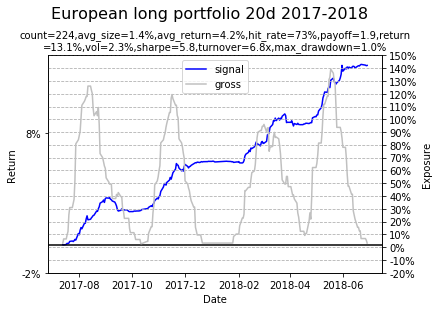

In [46]:
plot_account_curve(signal1_account(signal1_rel_long_Europe_20,30,50,data_dict_Europe["Volume"],data_dict_Europe["Date"],0.1),
                   "Date","European long portfolio 20d 2017-2018",[6,4])

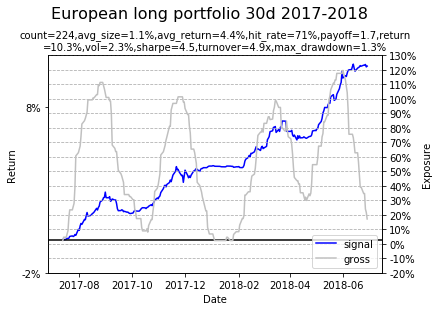

In [47]:
plot_account_curve(signal1_account(signal1_rel_long_Europe_30,30,50,data_dict_Europe["Volume"],data_dict_Europe["Date"],0.1),
                   "Date","European long portfolio 30d 2017-2018",[6,4])

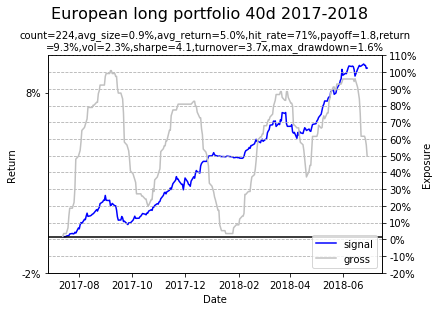

In [48]:
plot_account_curve(signal1_account(signal1_rel_long_Europe_40,30,50,data_dict_Europe["Volume"],data_dict_Europe["Date"],0.1),
                   "Date","European long portfolio 40d 2017-2018",[6,4])

#### 4.1.2 Europe short

In [49]:
# Short signals Europe
signal1_abs_short_Europe=signal1_df_date(data_dict_Europe['Date'],abs_return_Europe,abs_return_Europe,-1000,-2,data_dict_Europe['Revision'],-1000,-0.03,abs_return_Europe,-1000,1000,40,False,False,1)
signal1_rel_short_Europe=signal1_df_date(data_dict_Europe['Date'],abs_return_Europe,rel_return_Europe,-1000,-2,data_dict_Europe['Revision'],-1000,-0.03,abs_return_Europe,-1000,1000,40,False,False,1)
size_Europe=signal1_abs_short_Europe.apply(lambda x:get_market_cap(x.name[0],x.name[1],data_dict_Europe["Market cap"],data_dict_Europe["Date"]) )
large_signal1_abs_short_Europe_40=signal1_abs_short_Europe.loc[:,size_Europe>5000]
large_signal1_rel_short_Europe_40=signal1_rel_short_Europe.loc[:,size_Europe>5000]

In [50]:
# Other short holding period variations in Europe
signal1_abs_short_Europe_20=signal1_df_date(data_dict_Europe['Date'],abs_return_Europe,abs_return_Europe,-1000,-2,data_dict_Europe['Revision'],-1000,-0.03,abs_return_Europe,-1000,1000,20,False,False,1)
signal1_abs_short_Europe_30=signal1_df_date(data_dict_Europe['Date'],abs_return_Europe,abs_return_Europe,-1000,-2,data_dict_Europe['Revision'],-1000,-0.03,abs_return_Europe,-1000,1000,30,False,False,1)
signal1_rel_short_Europe_20=signal1_df_date(data_dict_Europe['Date'],abs_return_Europe,rel_return_Europe,-1000,-2,data_dict_Europe['Revision'],-1000,-0.03,abs_return_Europe,-1000,1000,20,False,False,1)
signal1_rel_short_Europe_30=signal1_df_date(data_dict_Europe['Date'],abs_return_Europe,rel_return_Europe,-1000,-2,data_dict_Europe['Revision'],-1000,-0.03,abs_return_Europe,-1000,1000,30,False,False,1)

large_signal1_abs_short_Europe_20=signal1_abs_short_Europe_20.loc[:,size_Europe>5000]
large_signal1_abs_short_Europe_30=signal1_abs_short_Europe_30.loc[:,size_Europe>5000]
large_signal1_rel_short_Europe_20=signal1_rel_short_Europe_20.loc[:,size_Europe>5000]
large_signal1_rel_short_Europe_30=signal1_rel_short_Europe_30.loc[:,size_Europe>5000]

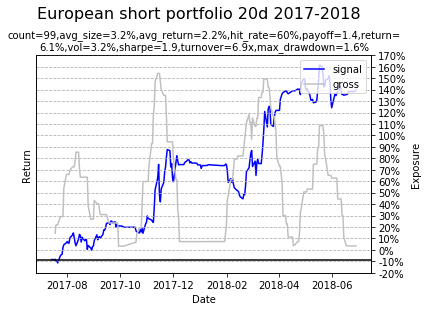

In [51]:
plot_account_curve(signal1_account(-large_signal1_rel_short_Europe_20,30,50,data_dict_Europe["Volume"],data_dict_Europe["Date"],0.1),
                   "Date","European short portfolio 20d 2017-2018",[6,4])

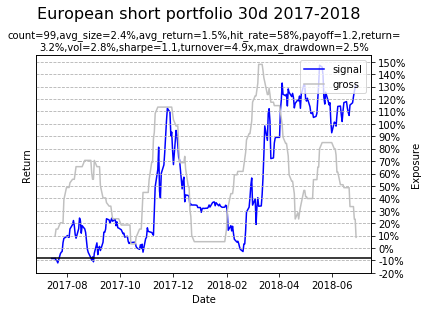

In [52]:
plot_account_curve(signal1_account(-large_signal1_rel_short_Europe_30,30,50,data_dict_Europe["Volume"],data_dict_Europe["Date"],0.1),
                   "Date","European short portfolio 30d 2017-2018",[6,4])

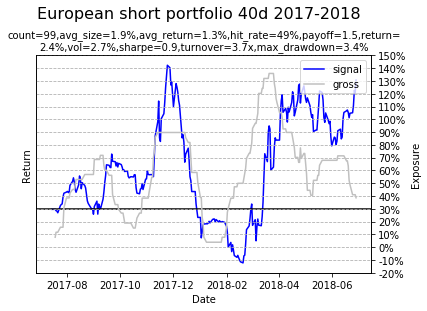

In [53]:
plot_account_curve(signal1_account(-large_signal1_rel_short_Europe_40,30,50,data_dict_Europe["Volume"],data_dict_Europe["Date"],0.1),
                   "Date","European short portfolio 40d 2017-2018",[6,4])

#### 4.1.3 Europe portfolio

In [54]:
# Europe portfolio
Europe_LS_40=signal1_account_LS(signal1_abs_long_Europe_40, large_signal1_abs_short_Europe_40, 30, 15, 50, data_dict_Europe["Volume"],
                   data_dict_Europe["Date"], 0.1, True, abs_return_Europe, abs_return_Europe.loc["SX5E Index"],0,'constant',8,8)

In [55]:
Europe_LS_20=signal1_account_LS(signal1_abs_long_Europe_30, large_signal1_abs_short_Europe_20, 30, 15, 50, data_dict_Europe["Volume"],
                   data_dict_Europe["Date"], 0.1, True, abs_return_Europe, abs_return_Europe.loc["SX5E Index"],0,'constant',8,8)

In [56]:
Europe_LS_30=signal1_account_LS(signal1_abs_long_Europe_30, large_signal1_abs_short_Europe_30, 30, 15, 50, data_dict_Europe["Volume"],
                   data_dict_Europe["Date"], 0.1, True, abs_return_Europe, abs_return_Europe.loc["SX5E Index"],0,'constant',8,8)

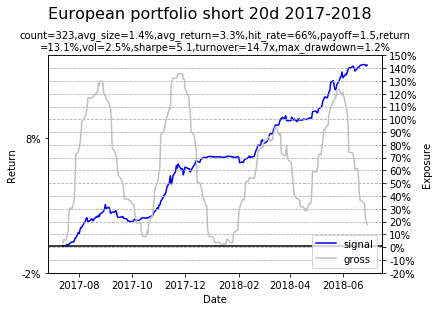

In [57]:
plot_account_curve(Europe_LS_20, "Date","European portfolio short 20d 2017-2018",[6,4])

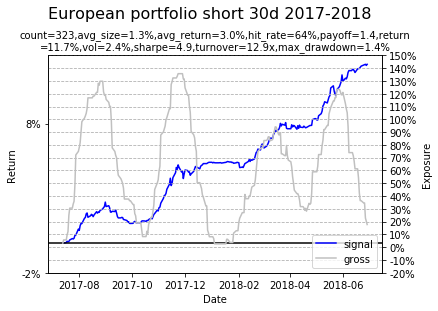

In [58]:
plot_account_curve(Europe_LS_30, "Date","European portfolio short 30d 2017-2018",[6,4])

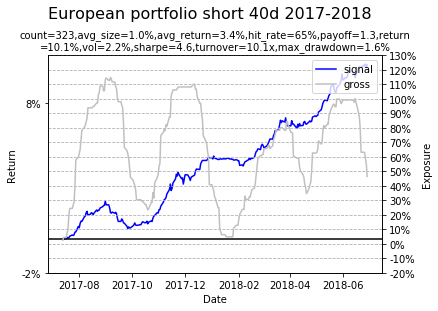

In [59]:
plot_account_curve(Europe_LS_40, "Date","European portfolio short 40d 2017-2018",[6,4])

### 4.2 US base

#### 4.2.1 US long

In [60]:
# Long signals US
signal1_abs_long_US_40=signal1_df_date(data_dict_US['Date'],abs_return_US,abs_return_US,1,1000,data_dict_US['Revision'],0.05,1000,abs_return_US,-1000,1000,40,False,False,1)
signal1_rel_long_US_40=signal1_df_date(data_dict_US['Date'],abs_return_US,rel_return_US,1,1000,data_dict_US['Revision'],0.05,1000,abs_return_US,-1000,1000,40,False,False,1)

In [61]:
# Other variations of holding periods
signal1_abs_long_US_30=signal1_df_date(data_dict_US['Date'],abs_return_US,abs_return_US,1,1000,data_dict_US['Revision'],0.05,1000,abs_return_US,-1000,1000,30,False,False,1)
signal1_rel_long_US_30=signal1_df_date(data_dict_US['Date'],abs_return_US,rel_return_US,1,1000,data_dict_US['Revision'],0.05,1000,abs_return_US,-1000,1000,30,False,False,1)

signal1_abs_long_US_20=signal1_df_date(data_dict_US['Date'],abs_return_US,abs_return_US,1,1000,data_dict_US['Revision'],0.05,1000,abs_return_US,-1000,1000,20,False,False,1)
signal1_rel_long_US_20=signal1_df_date(data_dict_US['Date'],abs_return_US,rel_return_US,1,1000,data_dict_US['Revision'],0.05,1000,abs_return_US,-1000,1000,20,False,False,1)

#### 4.2.2 US short

In [62]:
# Long signals US
signal1_abs_short_US_40=signal1_df_date(data_dict_US['Date'],abs_return_US,rel_return_US,-1000,-2,data_dict_US['Revision'],-1000,-0.03,abs_return_US,-1000,1000,40,False,False,1)
signal1_rel_short_US_40=signal1_df_date(data_dict_US['Date'],abs_return_US,abs_return_US,-1000,-2,data_dict_US['Revision'],-1000,-0.03,abs_return_US,-1000,1000,40,False,False,1)

In [63]:
# Other variations
signal1_abs_short_US_30=signal1_df_date(data_dict_US['Date'],abs_return_US,rel_return_US,-1000,-2,data_dict_US['Revision'],-1000,-0.03,abs_return_US,-1000,1000,30,False,False,1)
signal1_rel_short_US_30=signal1_df_date(data_dict_US['Date'],abs_return_US,abs_return_US,-1000,-2,data_dict_US['Revision'],-1000,-0.03,abs_return_US,-1000,1000,30,False,False,1)

signal1_abs_short_US_20=signal1_df_date(data_dict_US['Date'],abs_return_US,rel_return_US,-1000,-2,data_dict_US['Revision'],-1000,-0.03,abs_return_US,-1000,1000,20,False,False,1)
signal1_rel_short_US_20=signal1_df_date(data_dict_US['Date'],abs_return_US,abs_return_US,-1000,-2,data_dict_US['Revision'],-1000,-0.03,abs_return_US,-1000,1000,20,False,False,1)

In [64]:
# SIZING COLUMN
size_US_short=signal1_abs_short_US_40.apply(lambda x:get_market_cap(x.name[0],x.name[1],data_dict_US["Market cap"],data_dict_US["Date"]),axis=0)

In [65]:
# APPLY the SIZING
large_signal1_abs_short_US_40=signal1_abs_short_US_40.loc[:,size_US_short>5000]
large_signal1_rel_short_US_40=signal1_rel_short_US_40.loc[:,size_US_short>5000]
large_signal1_abs_short_US_30=signal1_abs_short_US_30.loc[:,size_US_short>5000]
large_signal1_rel_short_US_30=signal1_rel_short_US_30.loc[:,size_US_short>5000]
large_signal1_abs_short_US_20=signal1_abs_short_US_20.loc[:,size_US_short>5000]
large_signal1_rel_short_US_20=signal1_rel_short_US_20.loc[:,size_US_short>5000]

#### 4.2.3 US portfolio

In [66]:
# US portfolio
US_LS_40=signal1_account_LS(signal1_abs_long_US_40, large_signal1_abs_short_US_40, 30, 15, 50, data_dict_US["Volume"],
                   data_dict_US["Date"], 0.1, True, abs_return_US, abs_return_US.loc["SPX Index"],0,'constant',8,8)

In [67]:
US_LS_30=signal1_account_LS(signal1_abs_long_US_30, large_signal1_abs_short_US_30, 30, 15, 50, data_dict_US["Volume"],
                   data_dict_US["Date"], 0.1, True, abs_return_US, abs_return_US.loc["SPX Index"],0,'constant',8,8)

In [68]:
US_LS_20=signal1_account_LS(signal1_abs_long_US_20, large_signal1_abs_short_US_20, 30, 15, 50, data_dict_US["Volume"],
                   data_dict_US["Date"], 0.1, True, abs_return_US, abs_return_US.loc["SPX Index"],0,'constant',8,8)

#### 4.2.4 US hedge portfolio

In [69]:
Hedge_abs_US_40=signal1_df_date(data_dict_US['Date'],abs_return_US,abs_return_US,-1000,-2,data_dict_US['Revision'],-1000,1000,abs_return_US,-1000,1000,40,False,False,1)
Hedge_rel_US_40=signal1_df_date(data_dict_US['Date'],abs_return_US,rel_return_US,-1000,-2,data_dict_US['Revision'],-1000,1000,abs_return_US,-1000,1000,40,False,False,1)


In [70]:
Hedge_abs_US_30=signal1_df_date(data_dict_US['Date'],abs_return_US,abs_return_US,-1000,-2,data_dict_US['Revision'],-1000,1000,abs_return_US,-1000,1000,30,False,False,1)
Hedge_rel_US_30=signal1_df_date(data_dict_US['Date'],abs_return_US,rel_return_US,-1000,-2,data_dict_US['Revision'],-1000,1000,abs_return_US,-1000,1000,30,False,False,1)
Hedge_abs_US_20=signal1_df_date(data_dict_US['Date'],abs_return_US,abs_return_US,-1000,-2,data_dict_US['Revision'],-1000,1000,abs_return_US,-1000,1000,20,False,False,1)
Hedge_rel_US_20=signal1_df_date(data_dict_US['Date'],abs_return_US,rel_return_US,-1000,-2,data_dict_US['Revision'],-1000,1000,abs_return_US,-1000,1000,20,False,False,1)


In [71]:
Hedge_size_US=Hedge_abs_US_40.apply(lambda x:get_market_cap(x.name[0],x.name[1],data_dict_US["Market cap"],data_dict_US["Date"]) )
small_hedge_abs_US_40=Hedge_abs_US_40.loc[:,Hedge_size_US<2000]
small_hedge_abs_US_30=Hedge_abs_US_30.loc[:,Hedge_size_US<2000]
small_hedge_abs_US_20=Hedge_abs_US_20.loc[:,Hedge_size_US<2000]
small_hedge_rel_US_40=Hedge_rel_US_40.loc[:,Hedge_size_US<2000]
small_hedge_rel_US_30=Hedge_rel_US_30.loc[:,Hedge_size_US<2000]
small_hedge_rel_US_20=Hedge_rel_US_20.loc[:,Hedge_size_US<2000]

In [72]:
hedge_LS_40=signal1_account_LS(small_hedge_abs_US_40, None, 30, 0, 25, data_dict_US["Volume"],data_dict_US["Date"], 0.1, True,\
                            abs_return_US, abs_return_US.loc["SPX Index"],0,'constant',8,None)

In [73]:
hedge_LS_30=signal1_account_LS(small_hedge_abs_US_30, None, 30, 0, 25, data_dict_US["Volume"],data_dict_US["Date"], 0.1, True,\
                            abs_return_US, abs_return_US.loc["SPX Index"],0,'constant',8,None)

In [74]:
hedge_LS_20=signal1_account_LS(small_hedge_abs_US_20, None, 30, 0, 25, data_dict_US["Volume"],data_dict_US["Date"], 0.1, True,\
                            abs_return_US, abs_return_US.loc["SPX Index"],0,'constant',8,None)

### 4.3 Asia base

In [75]:
# Long signals Asia
signal1_abs_long_Asia=signal1_df_date(data_dict_Asia['Date'],abs_return_Asia,abs_return_Asia,1,1000,data_dict_Asia['Revision'],0.03,1000,abs_return_Asia,-1000,1000,20,False,False,1)
signal1_rel_long_Asia=signal1_df_date(data_dict_Asia['Date'],abs_return_Asia,rel_return_Asia,1,1000,data_dict_Asia['Revision'],0.03,1000,rel_return_Asia,-1000,1000,20,False,False,1)

In [104]:
# Asian portfolio
Asia_LS_20=signal1_account_LS_Asia(signal1_abs_long_Asia, None, 30, 0, 50, data_dict_Asia["Volume"],data_dict_Asia["Date"], 0.1, True,\
                            abs_return_Asia, abs_return_Asia,data_dict_Asia["Mapping"],0,'constant',8,None)

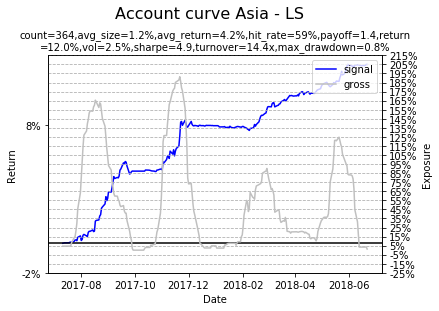

In [105]:
plot_account_curve(Asia_LS_20, "Date","Account curve Asia - LS",[6,4])

### 4.4 Global portfolio

In [ ]:
global_LS_40=signal1_account_combine(signal1_abs_long_Europe_40, large_signal1_abs_short_Europe_40,\
                                          signal1_abs_long_US_40, large_signal1_abs_short_US_40,\
                                            30,15,50,50,data_dict_global["Volume"],data_dict_global["Date"], True,\
                                          abs_return_Europe, abs_return_US,0.1, abs_return_Europe.loc["SX5E Index"], \
                                          abs_return_US.loc["SPX Index"], 0, 'constant', 8,8)

In [ ]:
global_LS_30=signal1_account_combine(signal1_abs_long_Europe_30, large_signal1_abs_short_Europe_30,\
                                          signal1_abs_long_US_30, large_signal1_abs_short_US_30,\
                                            30,15,50,50,data_dict_global["Volume"],data_dict_global["Date"], True,\
                                          abs_return_Europe, abs_return_US,0.1, abs_return_Europe.loc["SX5E Index"], \
                                          abs_return_US.loc["SPX Index"], 0, 'constant', 8,8)

In [ ]:
global_LS_20=signal1_account_combine(signal1_abs_long_Europe_20, large_signal1_abs_short_Europe_20,\
                                          signal1_abs_long_US_20, large_signal1_abs_short_US_20,\
                                            25,10,50,50,data_dict_global["Volume"],data_dict_global["Date"], True,\
                                          abs_return_Europe, abs_return_US,0.1, abs_return_Europe.loc["SX5E Index"], \
                                          abs_return_US.loc["SPX Index"], 0, 'constant', 8,8)

In [ ]:
plot_account_curve(global_LS_40, "Date","Global portfolio 40d 2017-2018",[6,4])

In [ ]:
plot_account_curve(global_LS_30, "Date","Global portfolio 30d 2017-2018",[6,4])

In [ ]:
plot_account_curve(global_LS_20, "Date","Global portfolio 20d 2017-2018",[6,4])

### 4.2 Sizing and volatility information

In [100]:
# Number of stocks
(Europe_LS_30[-1][0].sum(axis=1).mean(),Europe_LS_30[-1][2].sum(axis=1).mean(),US_LS_30[-1][0].sum(axis=1).mean(),US_LS_30[-1][2].sum(axis=1).mean(),Asia_LS_20[-1][0].sum(axis=1).mean())

(25.88888888888889, 11.528, 109.36693548387096, 28.9140625, 28.27309236947791)

In [106]:
# Average size
(Europe_LS_30[-1][1].mean(),Europe_LS_30[-1][3].mean(),US_LS_30[-1][1].mean(),US_LS_30[-1][3].mean(),Asia_LS_20[-1][1].mean())

(0.012300565418804723,
 -0.013810668205398419,
 0.003299473656283934,
 -0.006103296981386812,
 0.011832272234019984)

In [107]:
# Average Vol
(signal1_abs_long_Europe_30.apply(lambda x: signal1_vol(x,abs_return_Europe,30),axis=0).mean(),
 large_signal1_abs_short_Europe_30.apply(lambda x: signal1_vol(x,abs_return_Europe,30),axis=0).mean(),
 signal1_abs_long_US_30.apply(lambda x: signal1_vol(x,abs_return_US,30),axis=0).mean(),
 large_signal1_abs_short_US_30.apply(lambda x: signal1_vol(x,abs_return_US,30),axis=0).mean(),
 signal1_abs_long_Asia.apply(lambda x: signal1_vol(x,abs_return_Asia,30),axis=0).mean())

(0.015558704859015634,
 0.013048057892631878,
 0.01956455464547581,
 0.015231649721479607,
 0.01756017408070754)

In [110]:
 (hedge_LS_30[-1][0].sum(axis=1).mean(),
  hedge_LS_30[-1][1].mean(),
  small_hedge_abs_US_30.apply(lambda x: signal1_vol(x,abs_return_US,30),axis=0).mean())

(76.50965250965251, 0.004572863803457395, 0.019539344810640798)

### 4.3 get all the features

In [ ]:
feature_Europe1=aggregate_feature(data_dict_Europe["Date"],abs_return_Europe,rel_return_Europe,-1000,1000,data_dict_Europe["Revision"],
                                 -1000,1000,abs_return_Europe,40,1,data_dict_Europe["Market cap"],price_Europe,120,14,[50,150],
                                 "SX5E Index",data_dict_Europe["PE"],data_dict_Europe["PE premium"],
                                 data_dict_Europe["Property"]["Sector"])

In [ ]:
feature_US1=aggregate_feature(data_dict_US["Date"],abs_return_US,rel_return_US,-1000,1000,data_dict_US["Revision"],
                                 -1000,1000,abs_return_US,40,1,data_dict_US["Market cap"],price_US,120,14,[50,150],
                                 "SPX Index",data_dict_US["PE"],data_dict_US["PE premium"],
                                 data_dict_US["Property"]["Sector"])
                                 